El presente análisis de series temporales se basa en el volumen de venta de Diezmillo Choice en el periodo que comprende del 01-01-2015 al 22-09-2020, la base se compone de 2047 registros.

Las caracteristicas son la Fecha y el volumen de venta.

Los datos pertenecen a un particular.

Presenta: Carlos Alberto Rábago Figueroa

#### Importando Librerias necesarias

In [102]:
#Core Keras libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

#For data conditioning
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt

# Make results reproducible
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

In [103]:
# Other essential libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array

# Make our plot a bit formal
font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 10}
plt.rc('font', **font)

In [104]:
# Set input number of timestamps and training days

n_timestamp = 10
train_days = 1535  # number of days to train from
testing_days = 512 # number of days to be predicted
n_epochs = 50
filter_on = 1

model_type = 2

#### Se importa el dataset

In [105]:
dataset = pd.read_csv("datos.csv")
if filter_on == 1:
    dataset['Volumen'] = medfilt(dataset['Volumen'], 3)
    dataset['Volumen'] = gaussian_filter1d(dataset['Volumen'], 1.2)

In [106]:
dataset.head(1500)

,fecha,Volumen
0,2015-01-02,28.151975
1,2015-01-03,30.689112
2,2015-01-04,28.253833
3,2015-01-05,20.036879
4,2015-01-06,12.873568
...,...,...
1495,2019-03-15,14.985238
1496,2019-03-16,16.266488
1497,2019-03-17,16.629583
1498,2019-03-18,15.196382


#### Se establece el conjunto de datos de entrenamiento y de prueba

In [107]:
# Set number of training and testing data

train_set = dataset[0:train_days].reset_index(drop=True)
test_set = dataset[train_days: train_days+testing_days].reset_index(drop=True)
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values

#### Normalización de datos

In [108]:
# Normalize data first

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)


#### Se dividen los datos en el registro de tiempo

In [109]:
# Split data into n_timestamp

def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train.shape

(1525, 10, 1)

#### Configuracion de la red neuronal (Normal LSTM normal, Bidireccional y Stacked)

In [110]:
if model_type == 1:
    # Single cell LSTM
    model = Sequential()
    model.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
if model_type == 2:
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
if model_type == 3:
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

#### Inicia el entrenamiento

In [111]:
# Start training

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 64)
loss = history.history['loss']
epochs = range(len(loss))

Epoch 1/50
24/24 [==============================] - 8s 32ms/step - loss: 0.0794: 0s - loss: 0.080
Epoch 2/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0181
Epoch 3/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0129
Epoch 4/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0127
Epoch 5/50
24/24 [==============================] - 1s 33ms/step - loss: 0.0119
Epoch 6/50
24/24 [==============================] - 1s 35ms/step - loss: 0.0128: 0s - loss: 0.
Epoch 7/50
24/24 [==============================] - 1s 35ms/step - loss: 0.0130
Epoch 8/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0124
Epoch 9/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0120
Epoch 10/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0124
Epoch 11/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0124
Epoch 12/50
24/24 [==============================] - 1s 32ms/step - loss: 0.0115
Epoc

#### Obtener predicción

In [112]:
# Get predicted data

y_predicted = model.predict(X_test)

# 'De-normalize' the data

y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()

#### Mostrar resultados

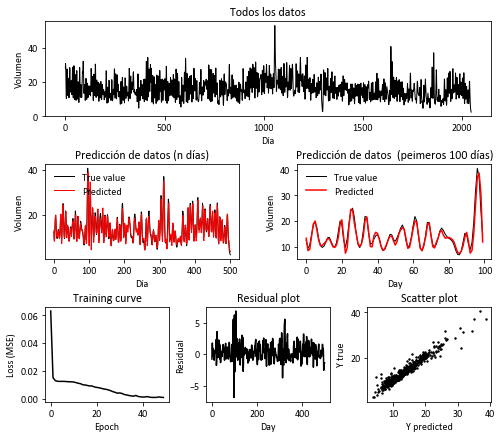

mse=2.02
r2=0.93


In [113]:
# Show results

plt.figure(figsize=(8,7))

plt.subplot(3, 1, 1)
plt.plot(dataset['Volumen'], color = 'black', linewidth=1, label = 'True value')
plt.ylabel("Volumen")
plt.xlabel("Día")
plt.title("Todos los datos")

plt.subplot(3, 2, 3)
plt.plot(y_test_descaled, color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled, color = 'red',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Volumen")
plt.xlabel("Día")
plt.title("Predicción de datos (n días)")

plt.subplot(3, 2, 4)
plt.plot(y_test_descaled[0:100], color = 'black', linewidth=1, label = 'True value')
plt.plot(y_predicted_descaled[0:100], color = 'red', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Volumen")
plt.xlabel("Day")
plt.title("Predicción de datos  (peimeros 100 días)")

plt.subplot(3, 3, 7)
plt.plot(epochs, loss, color='black')
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.title("Training curve")

plt.subplot(3, 3, 8)
plt.plot(y_test_descaled-y_predicted_descaled, color='black')
plt.ylabel("Residual")
plt.xlabel("Day")
plt.title("Residual plot")

plt.subplot(3, 3, 9)
plt.scatter(y_predicted_descaled, y_test_descaled, s=2, color='black')
plt.ylabel("Y true")
plt.xlabel("Y predicted")
plt.title("Scatter plot")

plt.subplots_adjust(hspace = 0.5, wspace=0.3)
plt.show()



mse = mean_squared_error(y_test_descaled, y_predicted_descaled)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(round(mse,2)))
print("r2=" + str(round(r2,2)))